TR AUTO - run 0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from iminuit.cost import LeastSquares

import irdetection.analysis.fitting.models as md
from irdetection.analysis.fitting.torchFitter import TorchFitter
from irdetection.analysis.fitting.models import Model
from irdetection.analysis.fitting.models import resonance_model_torch
from irdetection.analysis.fitting.searcher import ResonancePeakSearcher
from irdetection.graphics.plots import plot_fit
from irdetection.graphics.colours import Palette
from irdetection.graphics.typography import Typography, Font

In [2]:
# graphics settings
palette = Palette("Quantum Science", {
    'primary': "#046A3A",      # Deep ocean blue - sophisticated and trustworthy
    'secondary': '#1B263B',    # Midnight navy - elegant depth
    'accent': "#E65039",       # Vibrant coral - high-impact highlights
    'accent2': '#FFD23F',      # Golden yellow - energy and precision
    'background': '#F8F9FB',   # Ultra-clean off-white - pristine lab feel
    'background2': '#E8EDF3',  # Subtle blue-gray - sophisticated secondary
    'text_primary': '#1A1B23', # Rich charcoal - maximum readability
    'text_secondary': '#4A5568', # Cool gray - perfect for secondary text
    'status_error': '#E53E3E',  # Crisp red - clear error indication
    'neutral_light': "#F3F3F3",  # Cool light gray - subtle grid
    'neutral_dark': "#2D3748",   # Professional dark gray - strong borders
})

typography = Typography(
    title=Font('Palatino Linotype', 20, family='serif'),   
    subtitle=Font('Verdana', 16, family='sans-serif'),
    body=Font('Verdana', 13, family='sans-serif'),    
    caption=Font('Verdana', 11, family='sans-serif')  
)

In [3]:
R_true = 2.317

def read_peaks_data_2(filename):
    data_dict = {}       # stores the dataset values as NumPy arrays
    metadata_dict = {}   # stores the metadata (attributes) for each dataset
    def process_dataset(name, obj):
        if isinstance(obj, h5py.Dataset):
            bias_voltage = float(obj.attrs.get("bias_voltage"))
            bias_key = bias_voltage/R_true 
            if bias_key is not None:
                data_dict[bias_key] = obj[()]
                metadata_dict[bias_key] = {k: v for k, v in obj.attrs.items()}
            else:
                print(f"Warning: Dataset '{name}' missing 'bias_voltage' attribute.")

    with h5py.File(filename, 'r') as f:
        f.visititems(process_dataset)

    return data_dict, metadata_dict

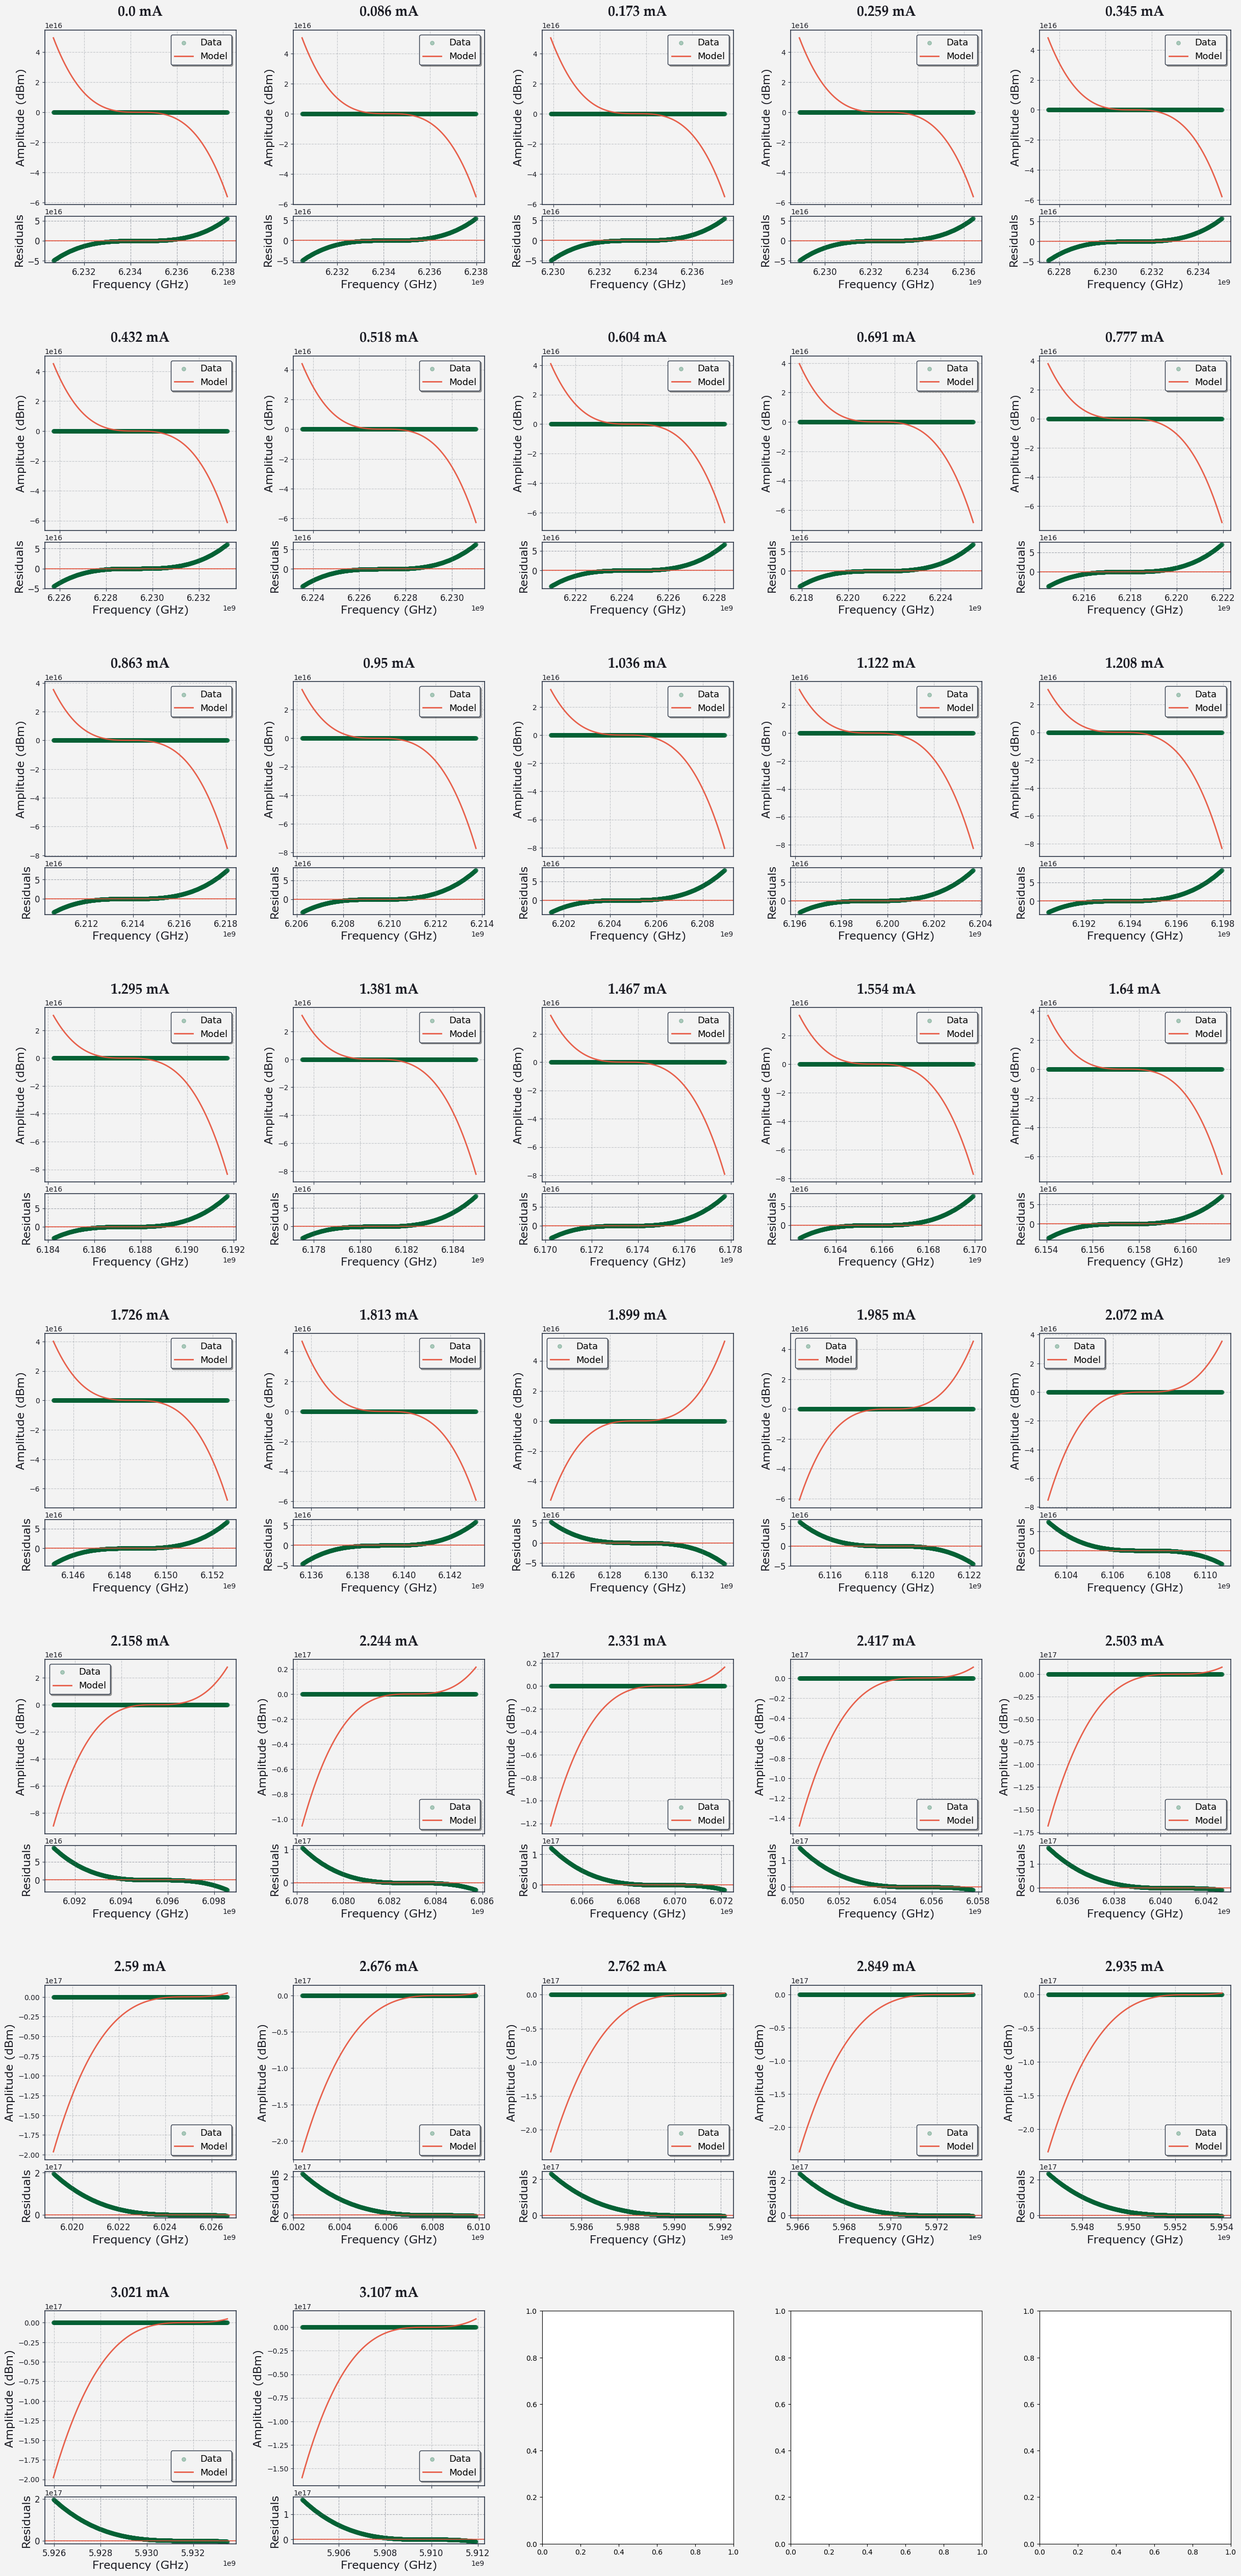

In [4]:
peak_data_dict, _ = read_peaks_data_2('../Experiments/TRswipeAuto/run-0/data/tr_sweep_data.h5')

resonance_frequneces_1 = []
bias_currents_1 = []
Qt_1 = []
Qc_1 = []

nof_peaks = len(peak_data_dict) - 4 # Exclude the last 4 peaks (assumed to be non-resonance peaks)
# Calculate grid size to accommodate all peaks - changed to 5 columns
nrows = (nof_peaks + 4) // 5  # Calculate required rows for 5 columns

fig, ax = plt.subplots(nrows, 5, figsize=(30, nrows * 8), gridspec_kw={'hspace':0.4, 'wspace':0.3})

row_iter = 0
col_iter = 0

pippo = 0
for i, (bias_current, peak_data) in enumerate(peak_data_dict.items()):
    # Break the cycle for the last 4 values of current:
    if i >= nof_peaks:
        break
    f = peak_data[0]
    I = peak_data[1]
    Q = peak_data[2]
    amp = np.sqrt(I**2 + Q**2)
    amp_dBm = 20 * np.log10(amp * 1e3)  # Convert to dBm
    peak_data = np.array([f, amp_dBm]).T
    # try to fit
    constraints = [("Qc", ">", "Qt")]
    searcher = ResonancePeakSearcher(version="T")
    model = resonance_model_torch
    fitter = TorchFitter(
        model_function=model,
        param_names=["f0", "phi", "Qt", "Qc", "A", "B", "C", "D", "K", "fmin"],
        data=peak_data,
        constraints=constraints,
        penalty_weight=1e4,
        epochs=6000
    )
    result = fitter.fit(searcher=searcher)
    # Extract the resonance frequency from the fitted parameters
    resonance_frequency = result.params['f0'] + searcher.params['fmin']
    resonance_frequneces_1.append(resonance_frequency)
    bias_currents_1.append(bias_current)
    fitted_params = result.params.copy()
    fitted_params['fmin'] = searcher.params['fmin']
    plot_fit(peak_data, md.resonance_model, fitted_params,
             title=f'{round(bias_current, 3)} mA',
             xlabel='Frequency (GHz)',
             ylabel='Amplitude (dBm)',
             palette=palette,
             typography=typography,
             ax=ax[row_iter, col_iter],
             rasterize_points=True)
    Qt_1.append(fitted_params['Qt'])
    Qc_1.append(fitted_params['Qc'])
    if pippo > 37:
        fig.delaxes(ax[row_iter, col_iter])
    col_iter += 1
    pippo += 1
    if col_iter >= 5:
        col_iter = 0
        row_iter += 1
plt.show()

NameError: name 'palette' is not defined

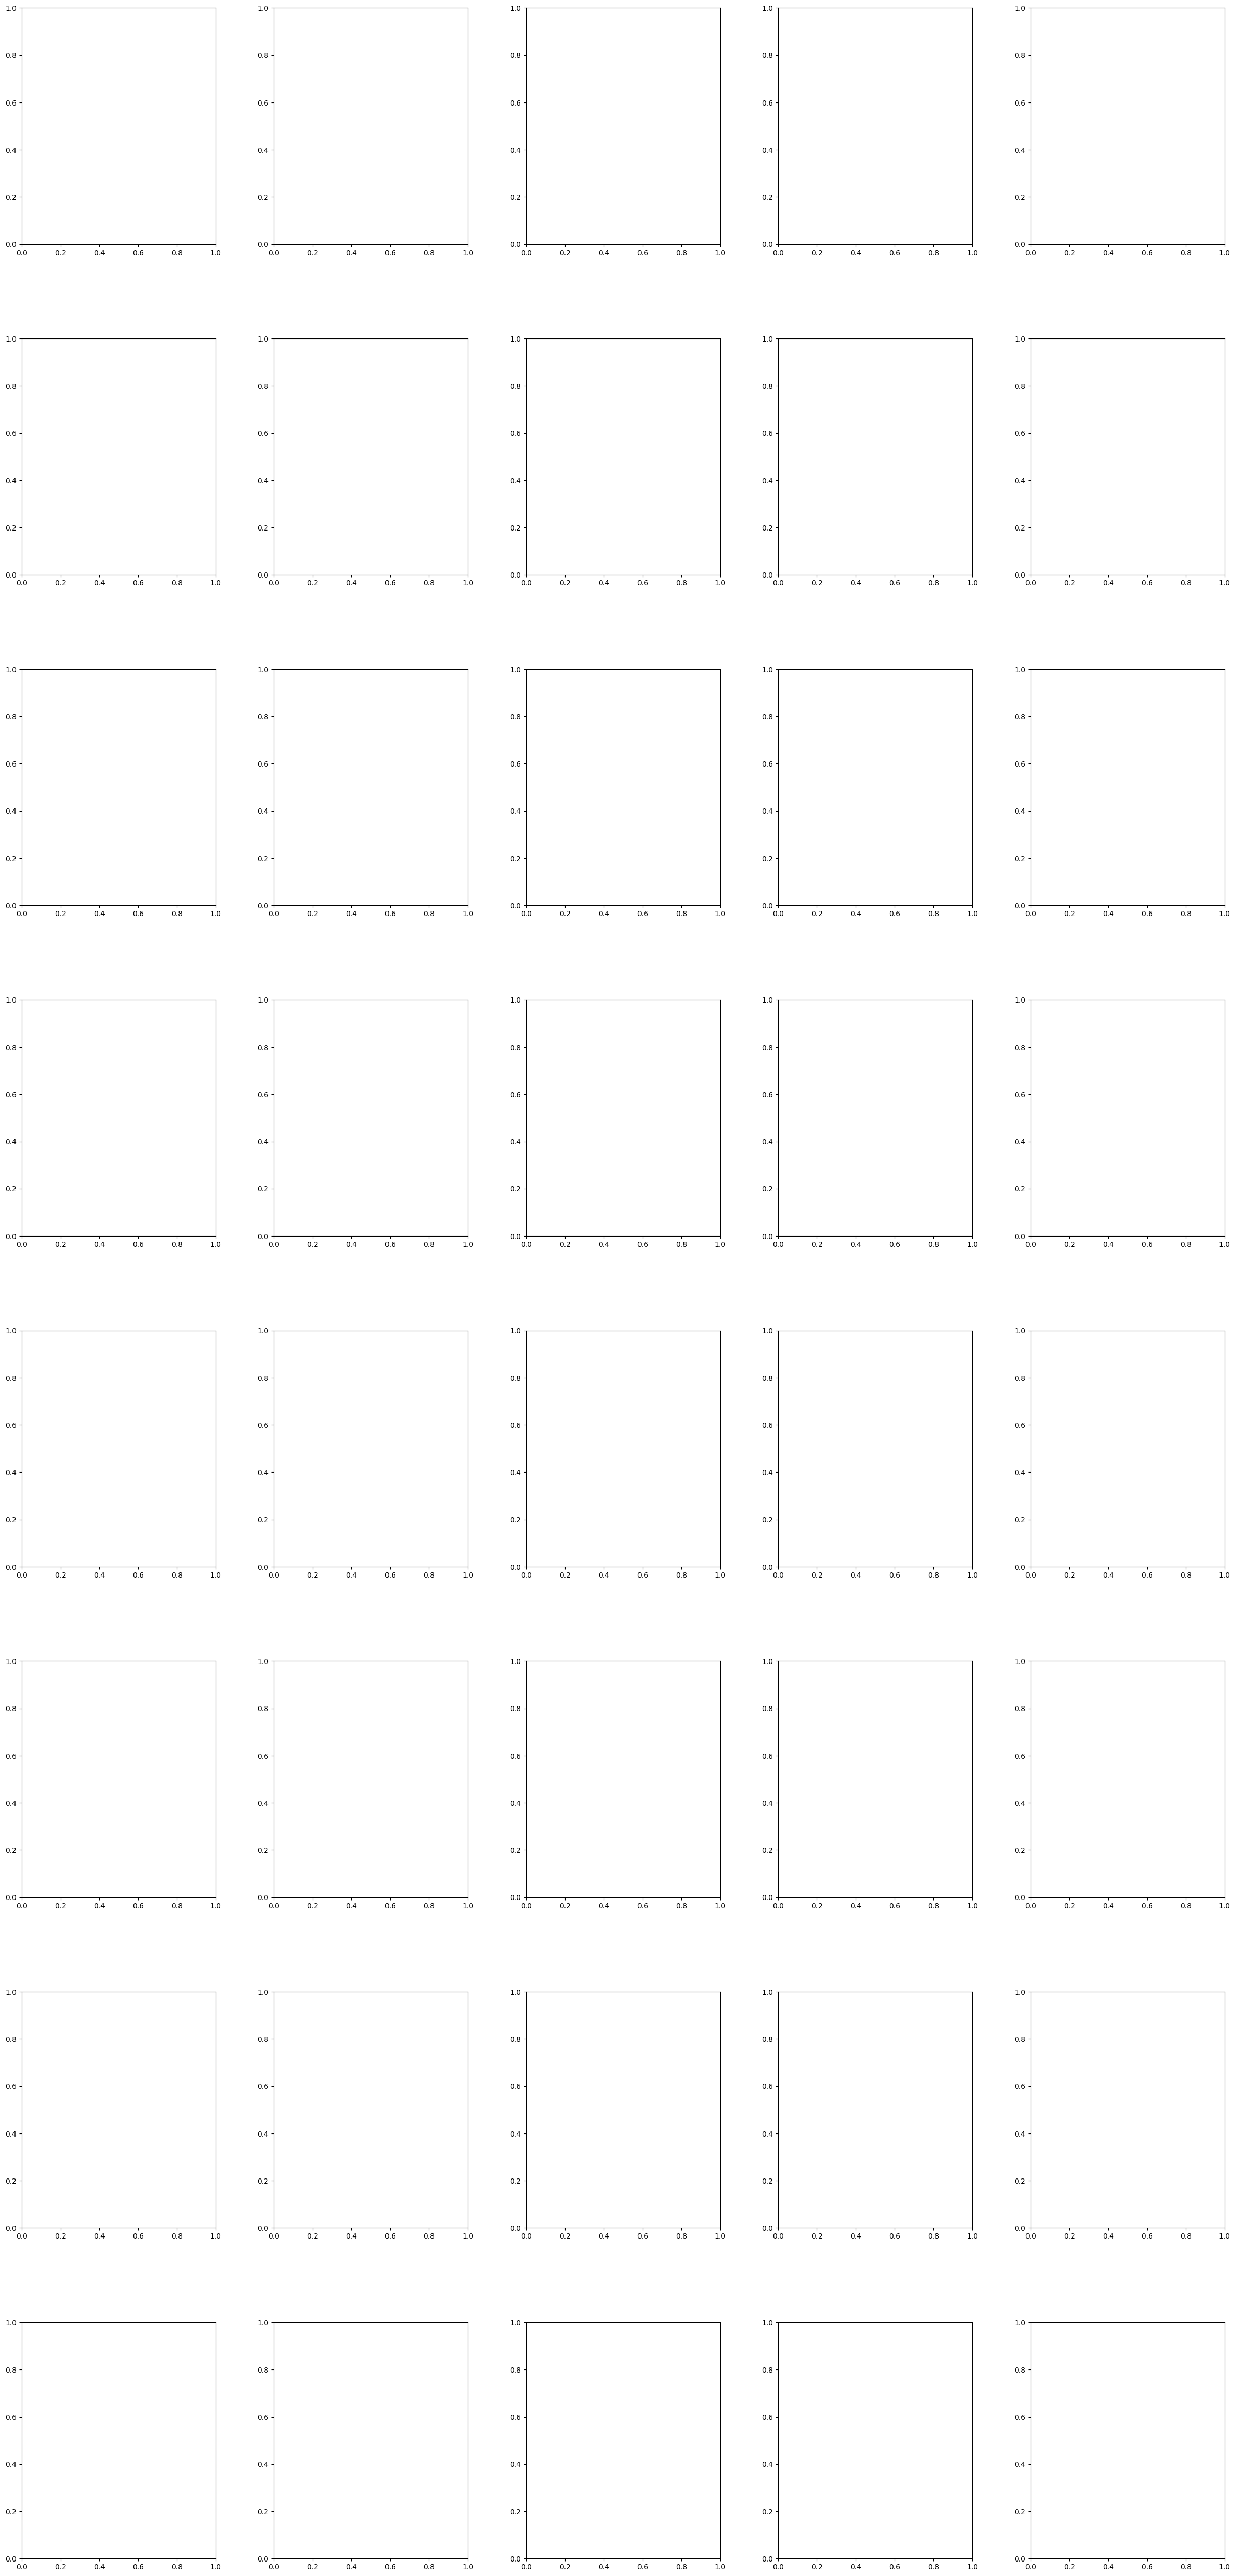

In [12]:
peak_data_dict, _ = read_peaks_data_2('../Experiments/TRswipeAuto/run-2/data/tr_sweep_data.h5')

resonance_frequneces_2 = []
bias_currents_2 = []
Qc_2 = []
Qt_2 = []

nof_peaks = len(peak_data_dict) - 4 # Exclude the last 4 peaks (assumed to be non-resonance peaks)
# Calculate grid size to accommodate all peaks - changed to 5 columns
nrows = (nof_peaks + 4) // 5  # Calculate required rows for 5 columns

fig, ax = plt.subplots(nrows, 5, figsize=(30, nrows * 8), gridspec_kw={'hspace':0.4, 'wspace':0.3})

row_iter = 0
col_iter = 0

pippo = 0
for i, (bias_current, peak_data) in enumerate(peak_data_dict.items()):
    # Break the cycle for the last 4 values of current:
    if i >= nof_peaks:
        break
    f = peak_data[0]
    I = peak_data[1]
    Q = peak_data[2]
    amp = np.sqrt(I**2 + Q**2)
    amp_dBm = 20 * np.log10(amp * 1e3)  # Convert to dBm
    peak_data = np.array([f, amp_dBm]).T
    # try to fit
    constraints = [("Qc", ">", "Qt")]
    searcher = ResonancePeakSearcher(version="T")
    model = resonance_model_torch
    fitter = TorchFitter(
        model_function=model,
        param_names=["f0", "phi", "Qt", "Qc", "A", "B", "C", "D", "K", "fmin"],
        data=peak_data,
        constraints=constraints,
        penalty_weight=1e4,
        epochs=6000
    )
    result = fitter.fit(searcher=searcher)
    resonance_frequency = result.params['f0'] + searcher.params['fmin']
    resonance_frequneces_2.append(resonance_frequency)
    bias_currents_2.append(bias_current)
    fitted_params = result.params.copy()
    fitted_params['fmin'] = searcher.params['fmin']
    plot_fit(peak_data, md.resonance_model, fitted_params,
             title=f'{round(bias_current, 3)} mA',
             xlabel='Frequency (GHz)',
             ylabel='Amplitude (dBm)',
             palette=palette,
             typography=typography,
             ax=ax[row_iter, col_iter],
             rasterize_points=True)
    Qc_2.append(fitted_params['Qc'])
    Qt_2.append(fitted_params['Qt'])
    if pippo > 37:
        fig.delaxes(ax[row_iter, col_iter])
    col_iter += 1
    pippo += 1
    if col_iter >= 5:
        col_iter = 0
        row_iter += 1
plt.show()

**NOTE:** This notebook is a copy of the original TRauto_charachterization, but all resonance fits use TorchFitter with the constraint Qc > Qt imposed.

In [10]:
# Renormalize the resonance frequencies with respect to the frequency at 0 bias current
resonance_frequneces_normalized = np.array(resonance_frequneces_1)
bias_currents = np.array(bias_currents_1)
resonance_frequneces_normalized -= resonance_frequneces_1[0]
resonance_frequneces_normalized /= resonance_frequneces_1[0] if resonance_frequneces_1[0] != 0 else 1

import matplotlib as mpl
# Fit resonance frequency vs bias current
model = md.parametric_resonator_peak_vs_bias_current
fitter = Fitter(model_function=model, 
                param_names=["a", "b"], 
                data=np.array([bias_currents, abs(resonance_frequneces_normalized)]).T, 
                loss_manager=LeastSquares,
                params_initial_guess={"a": 1, "b": 1}, # initial guess for the parameters
            )
result = fitter.fit()
fitted_params = result.values.to_dict()
#model: 0.5*((i**2 / a**2) + (i**4 / b**4))
data = np.array([bias_currents, abs(resonance_frequneces_normalized)]).T
mpl.rcParams['text.usetex'] = False
plot_fit(
    data=data,
    model=model,
    model_params=fitted_params,
    title=r'First peak resonance Frequency vs Bias Current',
    xlabel=r'Bias Current (mA)',
    ylabel=r'$\left|\Delta f / f_0\right|$',  # mathtext will still render this correctly
    data_label=r'Resonance Frequencies',
    model_label=(
        r'Fit: $\frac{1}{2}\left[\frac{I^2}{%.2f^2} + \frac{I^4}{%.2f^4}\right]$'
        % (fitted_params["a"], fitted_params["b"])
    ),
    palette=palette,
    typography=typography,
    rasterize_points=False,
)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(bias_currents, np.array(Qt_1), label='Qt_data', color='orange')
plt.scatter(bias_currents, np.array(Qc_1), label='Qc_data', color='green')
plt.xlabel('Bias Current (mA)')
plt.ylabel('Q factor')
plt.title('Peak 1 Internal quality factor vs Bias Current Higher resonator')
plt.legend()
plt.grid()
plt.show()

ValueError: Data must have at least two samples